## Mixture of Gaussians with pyMC3

In [1]:
import theano
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

## Generate Toy data with K components.

In [28]:
np.random.seed(42)
# Specify number of groups
K = 3
# Means 
mus = [ 0, 6,-8]
#Standard deviations,
sigmas = [ 1, .5, 3]
#Proportions
ps = [.2, .5,.3]
# Total amount of data
N = 200
# Stack data into a single array
one = np.random.normal(mus[0], sigmas[0], int(ps[0]*N))
two = np.random.normal(mus[1], sigmas[1], int(ps[1]*N))
three = np.random.normal(mus[2], sigmas[2], int(ps[2]*N))
X = np.r_[one,two,three]
X.shape

(200,)

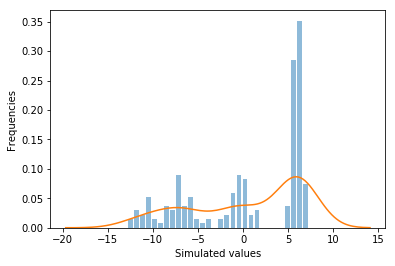

In [29]:
import seaborn as sns

## Plot the data as a histogram
plt.hist(X, bins=30, alpha=0.5, density=True, rwidth=0.8)

# Add axes labels
plt.xlabel('Simulated values')
plt.ylabel('Frequencies')
_=sns.kdeplot(X)

### Init cluster centers

In [30]:
m_0 = np.random.normal(0,5,size=K)  # Randomly or use init from KMeans++

## Build model

In [31]:
with pm.Model() as gmm:
    
    # Prior over pi
    pi = pm.Dirichlet('pi', a=np.ones(K))
    
    # Prior over z
    # z is the component that the data point is being sampled from.
    # Since we have N data points, z should be a vector with N elements.
    z = pm.Categorical('z', p=pi, shape=N)
    
    # Prior over the component means and standard deviations
    mu = pm.Normal('mu', mu=0., sd=10., shape=K, testval = m_0)
    
    sigma = pm.Gamma('sigma', alpha=2, beta=1, shape=K)
    
    # Specify the likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu[z], sd=sigma[z], observed=X)

Without a value passed to
step, PyMC3 will try to automatically assign an appropriate algorithm depending on the
type of variable, with No U-Turn Sampling (NUTS; Hoffman & Gelman, 2014) used for
continuous variables and Gibbs sampling used for discrete variables (CategoricalGibbsMetropolis
in PyMC3).

### Explicit Sampling definition

In [38]:
with gmm:
    continous = pm.NUTS(vars=[pi,sigma,mu])    
    discrete = pm.CategoricalGibbsMetropolis(vars=[z])
    # Start the sampler!
    trace = pm.sample(draws=2500, step=[continous, discrete], random_seed=42)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma, pi]
>CategoricalGibbsMetropolis: [z]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:26<00:00, 139.08draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [39]:
pm.summary(trace,varnames=['mu'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,-6.081966,3.368390,0.335306,-8.600017,-0.023168,2.015009,11.981187
mu__1,-2.212594,3.362617,0.335458,-8.371581,0.100427,2.008019,16.565277
mu__2,5.985179,0.048634,0.000473,5.893384,6.081454,11565.857154,1.000139


In [40]:
pmus = trace['mu'].mean(0)
pps = trace['pi'].mean(0)
psigmas = trace['sigma'].mean(0)
pmus,pps,psigmas

(array([-6.08196566, -2.21259417,  5.985179  ]),
 array([0.27136846, 0.23064334, 0.4979882 ]),
 array([2.12364363, 1.40192689, 0.47653671]))

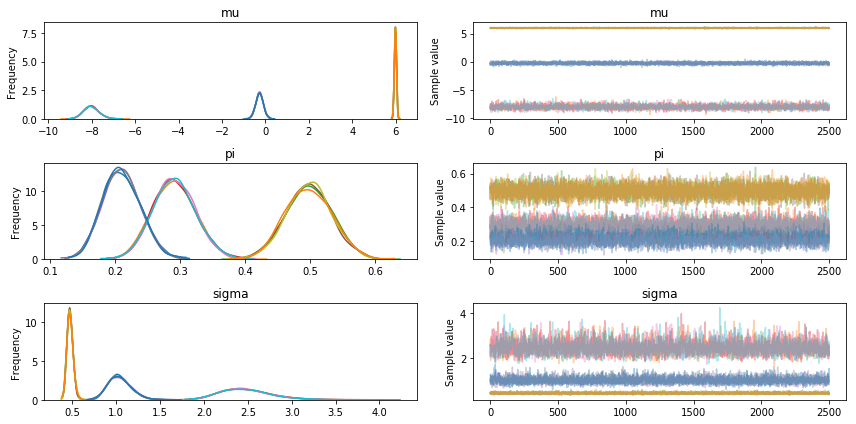

In [41]:
_=pm.traceplot(trace, varnames=['mu','pi','sigma']) # Specify which variables to plot
             
#lines={'mu':pmus,'pi':pps,'sigma':psigmas}) # Plots straight lines - useful

In [42]:
pm.stats.summary(trace,varnames=['mu','pi','sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,-6.081966,3.368390,0.335306,-8.600017,-0.023168,2.015009,11.981187
mu__1,-2.212594,3.362617,0.335458,-8.371581,0.100427,2.008019,16.565277
mu__2,5.985179,0.048634,0.000473,5.893384,6.081454,11565.857154,1.000139
pi__0,0.271368,0.047483,0.003526,0.173301,0.352749,3.319310,1.614115
pi__1,0.230643,0.046089,0.003510,0.158913,0.331575,3.173067,1.672812
pi__2,0.497988,0.035360,0.000345,0.429903,0.568580,10903.690791,0.999880
sigma__0,2.123644,0.675023,0.062589,0.858840,2.996825,2.268007,2.981834
sigma__1,1.401927,0.646456,0.062074,0.781328,2.737923,2.138087,4.051151
sigma__2,0.476537,0.034381,0.000346,0.412306,0.545458,9770.610478,0.999889


In [43]:
pm.gelman_rubin(trace,varnames=['mu','sigma','pi'])

{'mu': array([11.98118662, 16.56527726,  1.00013853]),
 'sigma': array([2.98183415, 4.0511509 , 0.99988924]),
 'pi': array([1.61411476, 1.67281163, 0.99987961])}

## Label switching problem

The ordering of the
component parameters being sampled in the first chain is not the same ordering of component
parameters in any of the other chains, leading to warnings of divergent chains.

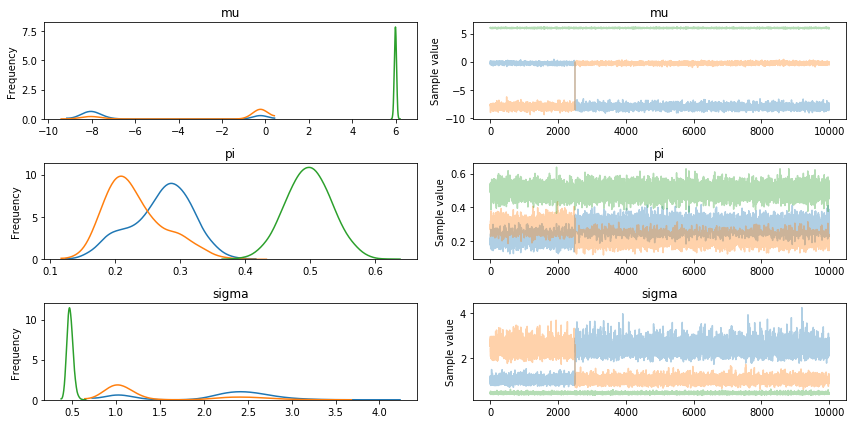

In [44]:
_=pm.traceplot(trace,varnames=['mu','pi','sigma'], combined=True)

One way to address this issue is by explicitly
providing the same starting value across chains for a component variable using the testval
argument so that the each chain is likely to have the same mean value assigned to each
component.

In [45]:
with pm.Model() as rgmm:
    
    p = pm.Dirichlet('p', a=np.ones(K))
    z = pm.Categorical('z', p=p, shape=N)
    mu = pm.Normal('mu', mu=0., sd=10., shape=K, testval = [-5, 0, 5])
    
    sigma = pm.HalfCauchy('sigma', beta=1., shape=K)

    Y_obs = pm.Normal('Y_obs', mu=mu[z], sd=sigma[z], observed=X)
    continous = pm.NUTS(vars=[p,sigma,mu])
    discrete = pm.CategoricalGibbsMetropolis(vars=[z])
    trace = pm.sample(draws=2000, nchains=2, step=[continous, discrete], random_seed=42)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma, p]
>CategoricalGibbsMetropolis: [z]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:08<00:00, 38.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


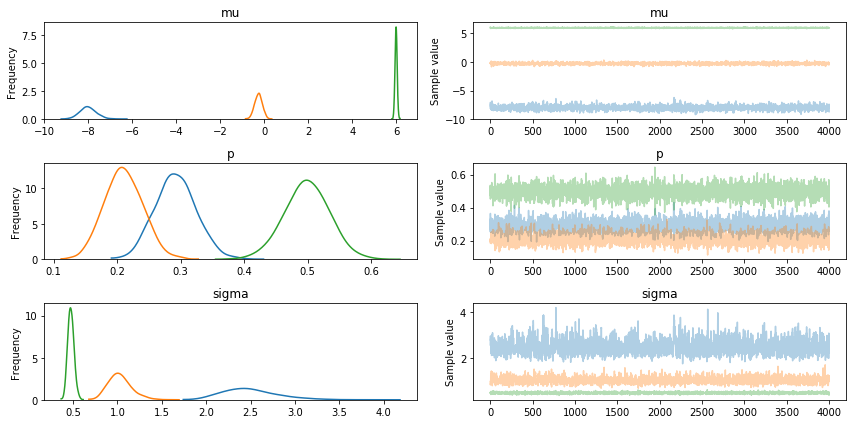

In [46]:
_=pm.traceplot(trace,varnames=['mu','p','sigma'], combined=True)

## Model Comparison using WAIC

In [47]:
## Build list of models
# We want a range of models ranging from K=2 to K=4
K_range = np.arange(2,5)
# Initialize lists
gmm_list = []
trace_list = []
# Specify some sampling options
draws = 500
nchains = 4

In [48]:
for K in K_range:
    model =  pm.Model(name = f'{K}-Group')
    gmm_list += [model]
    with model:
        
        # Prior over the component means and standard deviations
        mu = pm.Normal('mu', mu=0., sd=10., shape=K, testval = K*np.linspace(-5,5,K))
        sigma = pm.HalfCauchy('sigma', beta=1., shape=K)
        
        if K > 1:
            p = pm.Dirichlet('p', a=np.ones(K))
            z = pm.Categorical('z', p=p, shape=N)
            
            Y_obs = pm.Normal('Y_obs', mu=mu[z], sd=sigma[z], observed=X)
            # Specify the sampling algorithms to use
            cont = pm.NUTS(vars=[p, mu, sigma])
            dicr = pm.CategoricalGibbsMetropolis(vars=[z])
            steps = [cont,dicr]
        
        else:
            Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=X)
            step1 = pm.NUTS(vars=[mu, sigma])
            steps = [step1]
            
        trace_list += [pm.sample(draws=draws, nchains=nchains, tune=500, 
                                 step=steps, random_seed=42)]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [2-Group_sigma, 2-Group_mu, 2-Group_p]
>CategoricalGibbsMetropolis: [2-Group_z]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:27<00:00, 145.81draws/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [3-Group_sigma, 3-Group_mu, 3-Group_p]
>CategoricalGibbsMetropolis: [3-Group_z]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:29<00:00, 135.42draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [4-Group_sigma, 4-Group_mu, 4-Group_p]
>CategoricalGibbsMetropolis: [4-Group_z]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:30<00:00, 129.19draws/s]
The acceptance probability does not match the target. It is 0.8812306310214194, but should be close to 0.8. Try to increase the number of tuning steps.
There were 329

In [63]:
# Convert model and trace into dictionary pairs
dict_pairs = dict(zip(gmm_list,trace_list))
compare = pm.compare(dict_pairs, ic='LOO')

In [62]:
pm.compare?

In [64]:
compare

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
4-Group,507.04,31.34,0,1,26.47,0,1
3-Group,555.79,19.95,48.75,0,28.95,8.97,1
2-Group,787.18,37.55,280.14,0,32.6,18.62,1


In [51]:
gm = gmm_list[2]
tr = trace_list[2]

gm.basic_RVs

[4-Group_mu,
 4-Group_sigma_log__,
 4-Group_p_stickbreaking__,
 4-Group_z,
 4-Group_Y_obs]

In [52]:
pm.summary(tr,varnames=['4-Group_mu'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
4-Group_mu__0,-7.800521,4.634095,0.399514,-11.719738,-0.110889,14.092713,1.133043
4-Group_mu__1,-2.058945,3.000505,0.299420,-7.798726,0.126742,2.026295,10.320737
4-Group_mu__2,5.978619,0.051870,0.003063,5.884405,6.098609,108.601177,1.024542
4-Group_mu__3,-6.726801,4.010735,0.400251,-11.213974,-0.037067,2.046724,7.774251


100%|██████████| 2000/2000 [00:01<00:00, 1845.18it/s]


Text(0,0.5,'')

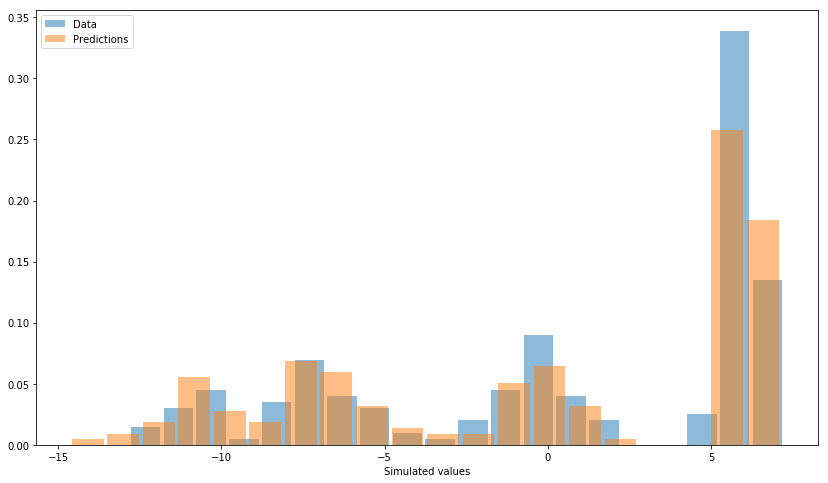

In [61]:
pp = pm.sample_ppc(model=gm, trace=tr)
plt.figure(figsize=(14,8))
# Plot original data
plt.hist(X, bins=20, alpha=0.5, density=True, label='Data', rwidth=0.9)
# Plot posterior predictives on top of that
plt.hist(np.random.choice(pp['4-Group_Y_obs'].flatten(),size=len(X)), bins=20, rwidth=0.9, alpha=0.5, density=True,label='Predictions')
# Add legend and axes labels
plt.legend()
plt.xlabel('Simulated values')
plt.ylabel('')